In [1174]:
# импорт библиотек
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
from sklearn import datasets
iris = datasets.load_iris()


# 5 Проблема качества данных

## Загрузка данных

In [1175]:
df = pd.read_csv('../../src/train.csv')
df_1 = df # для первого варианта построения модели
df_2 = df # для второго варианта построения модели
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## Обучение модели на плохо подготовленных данных

### Удаление всех пропущенных данных и категориальных переменных

In [1176]:
# оставляем все пропуски и категориальные переменные
non_categorical_type = df_1.describe().columns
df_1 = df_1.dropna()
df_1 = df_1[non_categorical_type]
df_1.head()

# обучение модели на плохих данных будут сделано ниже чтобы можно было видеть разницу сразу

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
1,2,1,1,38.0,1,0,71.2833
3,4,1,1,35.0,1,0,53.1000
6,7,0,1,54.0,0,0,51.8625
10,11,1,3,4.0,1,1,16.7000
11,12,1,1,58.0,0,0,26.5500


### Подготовка данных

#### Удаление не имеющих ценности столбцов

In [1177]:
# в выводе расписал подробнее. в целом не думаю что в них есть смысловая нагрузка
unimportant_columns = ['PassengerId', 'Name', 'Ticket']
df_2 = df_2.drop(columns=unimportant_columns)

In [1178]:
print(f"{(len(df_2.dropna()) / len(df_2)):.2f} данных не будут использованы для обучения, в случае пропуска обработки не качественных данных")

0.21 данных не будут использованы для обучения, в случае пропуска обработки не качественных данных


#### Заполните пропуски:
* `средним значением`
* `константой`
* `классом`

In [1179]:
df_2.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [1180]:
df_2.Embarked = df_2.Embarked.fillna('N')
df_2.Embarked.value_counts(dropna=False)

Embarked
S    644
C    168
Q     77
N      2
Name: count, dtype: int64

In [1181]:
#замена средним значением возраста пассажиров
df_2["Age"].fillna(df_2["Age"].mean(), inplace = True)

In [1182]:
# присвоение категории, есть кабина у пассажира или она не указана
df_2['Cabin'] = np.where(df_2['Cabin'].isnull(), 0, 1)

In [1183]:
df_2.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

#### Анализ выбросов данных и перевод категориальных переменных в числовые `Sex` и `Embarked`

In [1184]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_2['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])
df_2['Embarked_encoded'] = label_encoder.fit_transform(df['Embarked'])

In [1185]:
df_2.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Sex_encoded,Embarked_encoded
0,0,3,male,22.0,1,0,7.2500,0,S,1,2
1,1,1,female,38.0,1,0,71.2833,1,C,0,0
2,1,3,female,26.0,0,0,7.9250,0,S,0,2
3,1,1,female,35.0,1,0,53.1000,1,S,0,2
4,0,3,male,35.0,0,0,8.0500,0,S,1,2


In [1186]:
def detect_outliers(df_):
    # Создаем пустой словарь для хранения информации о выбросах
    outliers_info = {}
    
    # Итерируемся по числовым столбцам в DataFrame
    for column in df_.select_dtypes(include=['number']):
        Q1 = df_[column].quantile(0.25)
        Q3 = df_[column].quantile(0.75)
        IQR = Q3 - Q1

        # Определяем границы выбросов
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Отфильтровываем строки с выбросами
        outliers = df_[(df_[column] < lower_bound) | (df_[column] > upper_bound)]

        # Заполняем информацию о выбросах в словарь
        outliers_info[column] = {
            'count': outliers.shape[0],
            'percent': (outliers.shape[0] / df_.shape[0]) * 100,
            'rows': outliers.index.tolist()
        }
    
    return outliers_info

outliers_info = detect_outliers(df_2)
prefix = ''
columns_indexes = {} # содержит ключ название поле и значение лист с указанием индекса выброса значения
# Выводим информацию о выбросах для каждого числового признака
for column, info in outliers_info.items():
    if info['percent'] > 15.0:
        prefix = '> 15.0 >>>'
    print(f"{prefix} {column} | Количество строк с выбросами: {info['count']}, Строки с выбросами: {info['percent']:.2f} %")
    columns_indexes[column] = info['rows']
         

 Survived | Количество строк с выбросами: 0, Строки с выбросами: 0.00 %
 Pclass | Количество строк с выбросами: 0, Строки с выбросами: 0.00 %
 Age | Количество строк с выбросами: 66, Строки с выбросами: 7.41 %
 SibSp | Количество строк с выбросами: 46, Строки с выбросами: 5.16 %
> 15.0 >>> Parch | Количество строк с выбросами: 213, Строки с выбросами: 23.91 %
> 15.0 >>> Fare | Количество строк с выбросами: 116, Строки с выбросами: 13.02 %
> 15.0 >>> Cabin | Количество строк с выбросами: 204, Строки с выбросами: 22.90 %
> 15.0 >>> Sex_encoded | Количество строк с выбросами: 0, Строки с выбросами: 0.00 %
> 15.0 >>> Embarked_encoded | Количество строк с выбросами: 0, Строки с выбросами: 0.00 %


#### Построение графиков на основе датасета

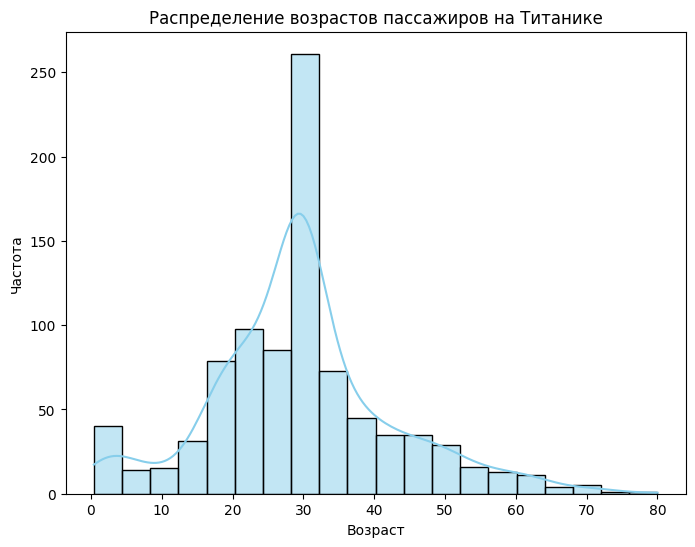

Есть небольшой выброс на гистограмме в левой части, длинный хвост вправо


In [1187]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем график распределения возрастов
plt.figure(figsize=(8, 6))
sns.histplot(df_2['Age'], bins=20, kde=True, color='skyblue')
plt.title('Распределение возрастов пассажиров на Титанике')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()
print("Есть небольшой выброс на гистограмме в левой части, длинный хвост вправо")

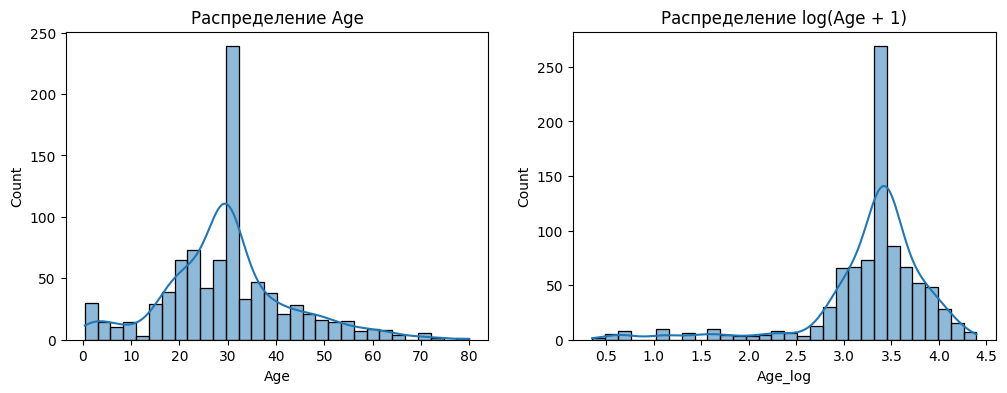

При попытке математического преобразования признака `Age` остался длинный хвост слева


In [1188]:
# Преобразуем признак Age логарифмически
df_2['Age_log'] = np.log(df_2['Age'] + 1)

# Создаем графики для сравнения распределений
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df_2['Age'], bins=30, kde=True)
plt.title('Распределение Age')

plt.subplot(1, 2, 2)
sns.histplot(df_2['Age_log'], bins=30, kde=True)
plt.title('Распределение log(Age + 1)')

plt.show()
print("При попытке математического преобразования признака `Age` остался длинный хвост слева")

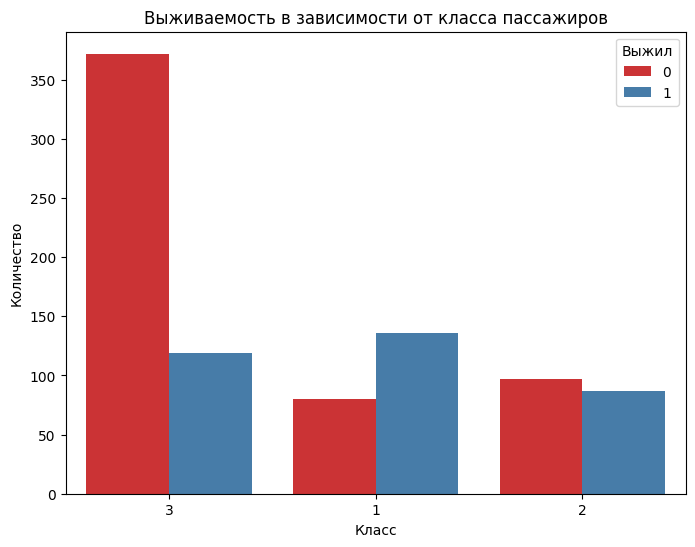

Выживших пассажиров 1 класса больше чем в других классах, и наоборот выживших меньше в 3, и не значительно во 2 классе


In [1189]:
# Преобразуем 'Pclass' и 'Survived' в категориальный формат
df_2['Pclass_'] = df_2['Pclass'].astype(str)
df_2['Survived_'] = df_2['Survived'].astype(str)

# Создаем график выживаемости в зависимости от класса
plt.figure(figsize=(8, 6))
sns.countplot(data=df_2, x='Pclass_', hue='Survived_', palette='Set1')
plt.title('Выживаемость в зависимости от класса пассажиров')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.legend(title='Выжил')
plt.show()
print("Выживших пассажиров 1 класса больше чем в других классах, и наоборот выживших меньше в 3, и не значительно во 2 классе")

In [1190]:
# удаляем не нужные вспомогательные поля
df_2.drop(columns='Pclass_', inplace=True)
df_2.drop(columns='Survived_', inplace=True)
df_2.drop(columns='Sex', inplace=True)
df_2.drop(columns='Embarked', inplace=True)
df_2.drop(columns='Age_log', inplace=True)
df_2

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_encoded,Embarked_encoded
0,0,3,22.000000,1,0,7.2500,0,1,2
1,1,1,38.000000,1,0,71.2833,1,0,0
2,1,3,26.000000,0,0,7.9250,0,0,2
3,1,1,35.000000,1,0,53.1000,1,0,2
4,0,3,35.000000,0,0,8.0500,0,1,2
...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,0,1,2
887,1,1,19.000000,0,0,30.0000,1,0,2
888,0,3,29.699118,1,2,23.4500,0,0,2
889,1,1,26.000000,0,0,30.0000,1,1,0


<Figure size 640x320 with 0 Axes>

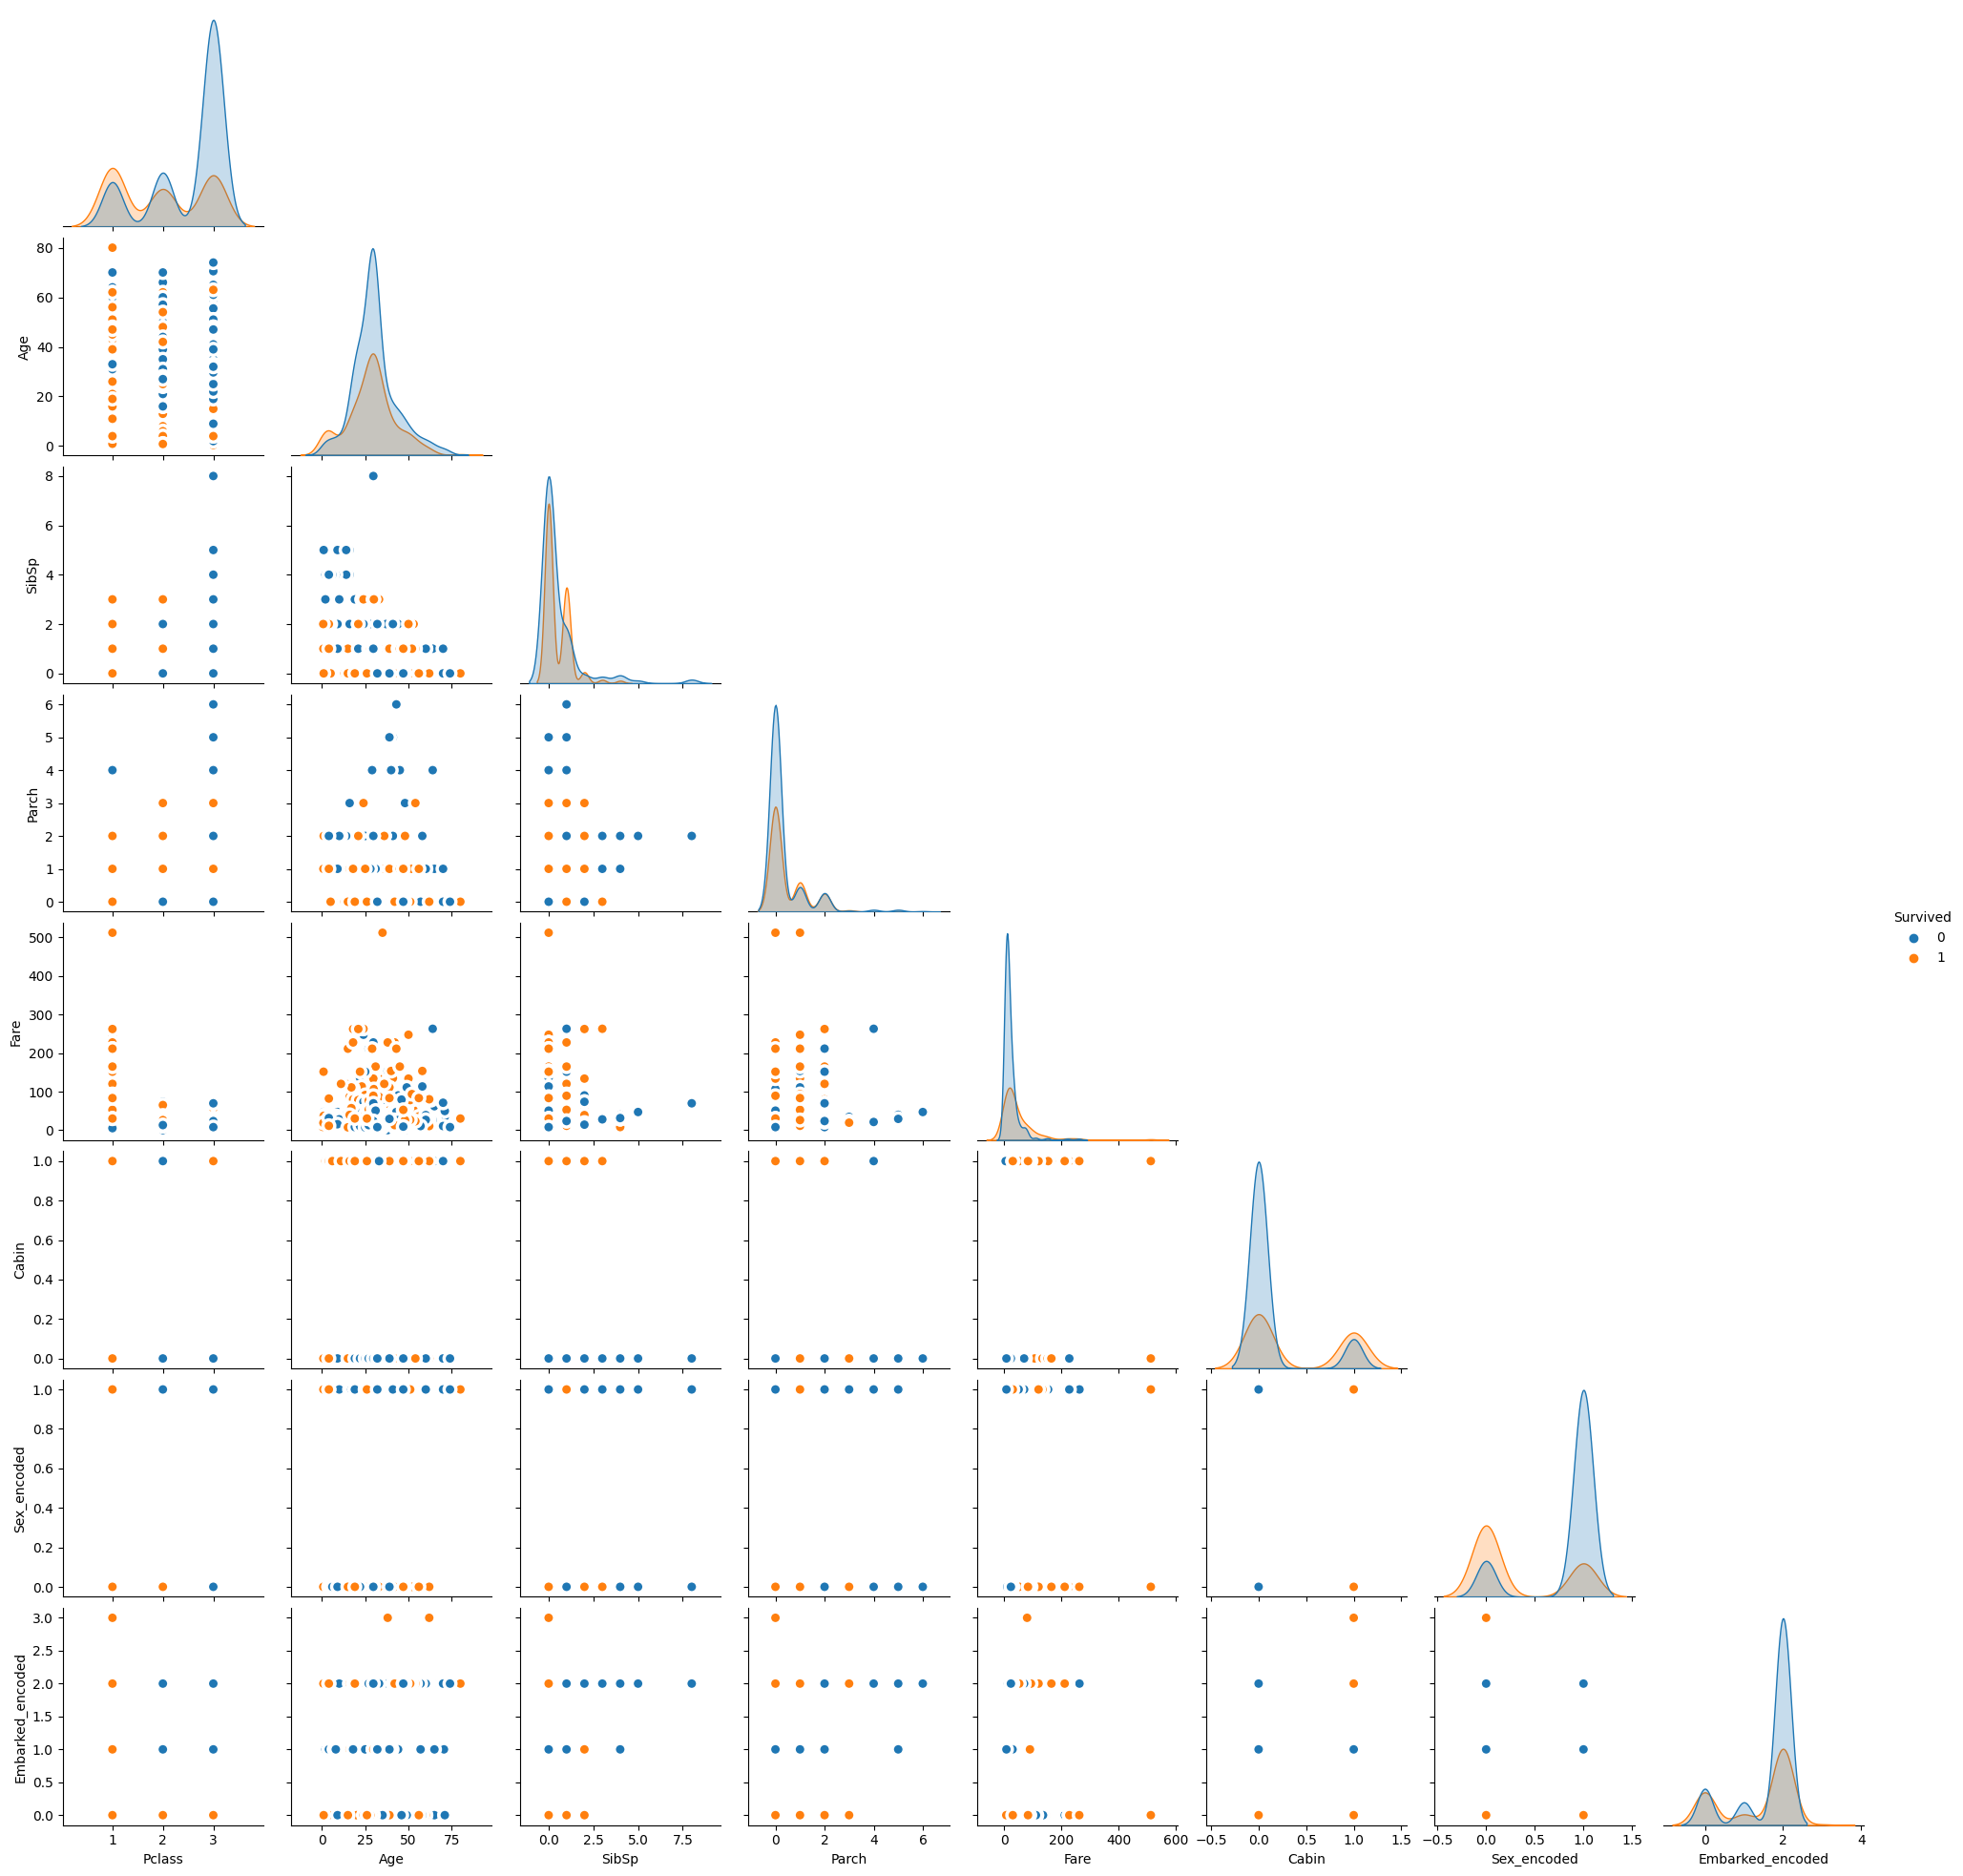

In [1191]:
plt.figure(figsize=(8, 4), dpi = 80)
sns.pairplot(df_2, kind="scatter", hue="Survived", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5), corner=True)
plt.show()

### Обучение 1 модели с удаленными данными и всеми категориальными переменными

In [1192]:
y = df_1['Survived']
X = df_1.drop(columns='Survived')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Не подготовленные данные")
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')

Не подготовленные данные
Accuracy: 0.70, Precision: 0.85, Recall: 0.77, F1-score: 0.81


### Обучение 2 модели с подготовленными данными
* разные варианты с удалением и без выбросов в данных для сравнения моделей

In [1193]:
y = df_2['Survived']
X = df_2.drop(columns='Survived')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Подготовленные без удаления выбросов")
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')

Подготовленные без удаления выбросов
Accuracy: 0.83, Precision: 0.76, Recall: 0.80, F1-score: 0.78


In [1194]:
df_3 = df_2.drop(columns_indexes['Parch'], errors='ignore')
y = df_3['Survived']
X = df_3.drop(columns='Survived')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Подготовленные с удаленными индексами полей с большими выбросами `Parch`")
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')

Подготовленные с удаленными индексами полей с большими выбросами `Parch`
Accuracy: 0.85, Precision: 0.84, Recall: 0.75, F1-score: 0.79


In [1195]:
df_4 = df_2.drop(columns_indexes['Cabin'], errors='ignore')
y = df_4['Survived']
X = df_4.drop(columns='Survived')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Подготовленные с удаленными индексами полей с большими выбросами `Cabin`")
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')

Подготовленные с удаленными индексами полей с большими выбросами `Cabin`
Accuracy: 0.79, Precision: 0.68, Recall: 0.56, F1-score: 0.61


In [1196]:
df_5 = df_2.drop(columns_indexes['Parch'], errors='ignore')
df_5 = df_2.drop(columns_indexes['Cabin'], errors='ignore')
y = df_5['Survived']
X = df_5.drop(columns='Survived')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Подготовленные с удаленными индексами полей с большими выбросами `Parch` и `Cabin`")
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')

Подготовленные с удаленными индексами полей с большими выбросами `Parch` и `Cabin`
Accuracy: 0.79, Precision: 0.68, Recall: 0.56, F1-score: 0.61


## Вывод
* на данных из которых были удалены все пропуски и все категориальные переменные `Accuracy ` составил `0.70` что довольно низкий показатель
* `0.21` данных не будут использованы для обучения, в случае простого удаления данных без обработки пропусков
* на подготовленных данных `Accuracy ` составил `0.79 от 0.83` что значительно лучше предыдущего результата
* при подготовке данных для второй модели обучения исключил следующие поля `['PassengerId', 'Name', 'Ticket']` так как они в явном виде не несут смысловой нагрузки, особенно ID, и если не обладать доп знаниями по кодировке `Ticket` или не обработать имя пассажира дополнительно, чтобы сделать более глубокий анализ (например, `Mr.`, `Mrs.`, `Dr.` и т.д.)
* Для пропусков данных использовал следующие преобразования:
   * `Cabin` так как большое количество данных отсутствуем, сделал признак о наличие или отсутствии записи о наличии каюты `0, 1`
   * `Age` пропуски заменил на `mean`
   * `Embarked` проставил класс `N`
* `Parch` и `Cabin` имеют большое количество выбросов `23.91 %` и `22.90 %` для принятия решения обучил разные варианты с удалением выбросов и без, сравнение и выводы ниже
* На графике видно что больше всего выживших это пассажиры `1 класса`, и наоборот меньше всего выживших в пассажирах `3 класса`

Сравнительная таблица метрик для разных вариантов обработки данных:

| Сценарий обработки данных                          | Accuracy | Precision | Recall | F1-score |
|----------------------------------------------------|----------|-----------|--------|----------|
| Не подготовленные данные                            | 0.70     | 0.85      | 0.77   | 0.81     |
| Подготовленные без удаления выбросов                | 0.83     | 0.76      | 0.80   | 0.78     |
| Подготовленные с удаленными индексами полей с большими выбросами `Parch`  | **0.85**     | **0.84**      | 0.75   | 0.79     |
| Подготовленные с удаленными индексами полей с большими выбросами `Cabin`  | 0.79     | 0.68      | 0.56   | 0.61     |
| Подготовленные с удаленными индексами полей с большими выбросами `Parch` и `Cabin`  | 0.79     | 0.68      | 0.56   | 0.61     |

**Вывод по разным метрикам модели:**

1. Обработка выбросов и подготовка данных приводит к улучшению Accuracy (общей точности модели)
2. Удаление признака `Parch` привело к незначительному увеличению метрик по сравнению с подготовленными данными без удаления выбросов, но при этом Precision вырос что говорит о том что модель редко делает ложно положительные расчеты 
3. Удаление признака `Cabin` привело к некоторому снижению точности (`Precision`) и F1-score модели, но при этом уровень полноты (`Recall`) увеличился.
4. Удаление как признака `Parch`, так и `Cabin` не привело к улучшению метрик по сравнению с удалением только `Cabin`.